# **ECG Anomaly Detection**

In [1]:
# Import Library.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (7, 4)})

# Load Dataset.
"""
This data comes with 140 features, where the class is given at the last of the dataset, i.e., at the 140th column.
If the Class value is 0, then "Normal" or otherwise "Abnormal".
"""
data = pd.read_csv(
    "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv", header=None
)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [2]:
# Class Frequency.
data[140].value_counts()

1.0    2919
0.0    2079
Name: 140, dtype: int64

In [3]:
# Split Dataset into Features and Target Set.
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Split Dataset into Training and Test Set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_train, y_test = y_train.astype(bool), y_test.astype(bool)

# Feature Scaling.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [4]:
# Separate the data for normal ECGs from that of abnormal ones.

# Normal ECG.
normal_train_data = X_train[y_train]
normal_test_data = X_test[y_test]

# Abnormal ECG.
ab_train_data = X_train[~y_train]
ab_test_data = X_test[~y_test]

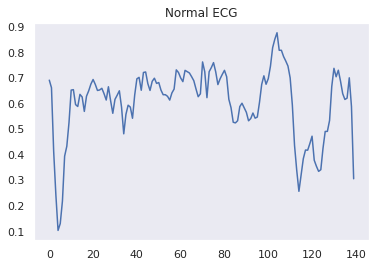

In [5]:
# Plot Normal ECG.
plt.plot(np.arange(normal_train_data.shape[1]), normal_train_data[0])
plt.grid()
plt.title("Normal ECG")
plt.show()

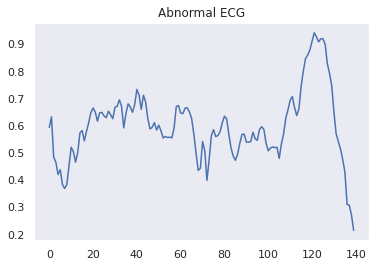

In [6]:
# Plot Abnormal ECG.
plt.plot(np.arange(ab_train_data.shape[1]), ab_train_data[0])
plt.grid()
plt.title("Abnormal ECG")
plt.show()

### **This model uses an AutoEncoder architecture for Anomaly Detection.**

Autoencoders are a specific type of feedforward neural network. It compresses the input into a so-called "code" of lower dimensionality and then tries to reconstruct the output from this code. It is an unsupervised learning model. Autoencoders consists of two parts, i.e., Encoder and Decoder. So in simple terms, we provide input to the autoencoder, and then it tries to re-create the output from it.

#### **So how will the model detect anomalies?**

We create an encoder and a decoder using an ANN architecture. We provide the ECG data as input, and the model will try to reconstruct it. The error between the original data and the reconstructed output will be called the **reconstruction error**. Based on this reconstruction error, we classify an ECG as anomalous or normal. To do this, we are going to train the model only on the normal ECG data but it will be tested on the entire test set so that when an abnormal ECG is provided as input, the autoencoder will try to reconstruct it but since it has been only trained on normal ECG data the output will have a larger reconstruction error. We will also define a minimum threshold for the error, i.e., if the reconstruction error is above the threshold then it will be categorized as anomalous.

In Keras, there are mainly 3 APIs for defining a model. They are:

*   Sequential API
*   Functional API
*   Subclassing API

The reason we used Subclassing API is that it provides good control over the model as compared to Sequential API, as in Sequential API, the add function implicitly passes the output of one layer into the next and, we just get the output from the final layer. But in the case of subclassing API, the forward pass is explicitly defined, as we can see in the $call()$ function. For this problem, the Subclassing API suits best.

The subclassing API is used to create a model class called **detector**. It inherits from the Model class of Keras from which both the sequential model and the functional API also inherit. First using $super()$, we pass the parameters to the parent class, then we define our constructor, which has the encoder and decoder. Then we implement the forward pass in the $call()$ function.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses


class detector(Model):
    # The Model has two parts, i.e., Encoder and Decoder.
    def __init__(self):
        super(detector, self).__init__()
        self.encoder = tf.keras.Sequential(
            [
                layers.Dense(32, activation="relu"),
                layers.Dense(16, activation="relu"),
                layers.Dense(8, activation="relu"),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                layers.Dense(16, activation="relu"),
                layers.Dense(32, activation="relu"),
                layers.Dense(140, activation="sigmoid"),
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Compile and Train the Model.
autoencoder = detector()
autoencoder.compile(optimizer="adam", loss="mae")
autoencoder.fit(
    normal_train_data,
    normal_train_data,
    epochs=100,
    batch_size=512,
    validation_data=(normal_test_data, normal_test_data),
)

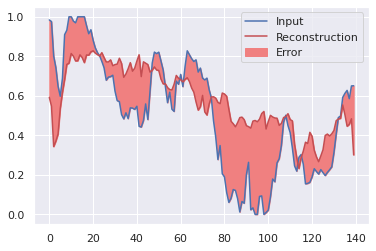

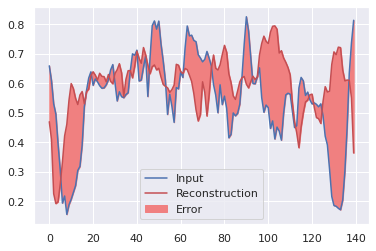

In [8]:
# Plot the original ECG with the reconstructed ones and show the Error.
def plot(data, n):
    # Encodes in Lower Dimensions.
    enc_img = autoencoder.encoder(data)
    # Decode or Reconstruct.
    dec_img = autoencoder.decoder(enc_img)
    plt.plot(data[n], "b")
    plt.plot(dec_img[n], "r")
    plt.fill_between(np.arange(140), data[n], dec_img[n], color="lightcoral")
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()


plot(normal_test_data, 0)
plot(ab_test_data, 0)

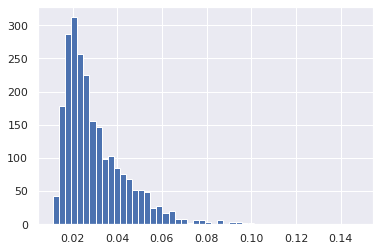

In [9]:
# Loss Error Graph.
reconstructed = autoencoder(normal_train_data)
train_loss = losses.mae(reconstructed, normal_train_data).numpy()
plt.hist(train_loss, bins=50)
plt.show()

In [10]:
# An ECG datapoint is anomalous if it is greater than a threshold. We can set the threshold according to our choice.
mean_error = np.mean(train_loss)
std_error = np.std(train_loss)

# We set the threshold to "mean_error + (5*std_error)".
threshold = mean_error + (5 * std_error)
print(threshold)

0.10626470421072479


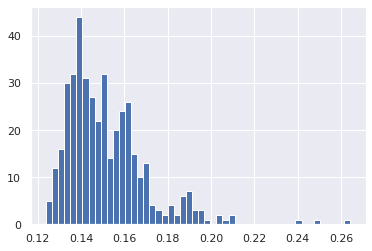

In [11]:
# Testing the Threshold.
reconstructed = autoencoder(ab_test_data)
train_loss_ab = losses.mae(reconstructed, ab_test_data).numpy()
plt.hist(train_loss_ab, bins=50)
plt.show()

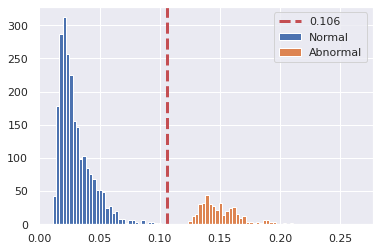

In [12]:
plt.hist(train_loss, bins=50, label="Normal")
plt.hist(train_loss_ab, bins=50, label="Abnormal")
plt.axvline(
    threshold,
    color="r",
    linewidth=3,
    linestyle="dashed",
    label="{:0.3f}".format(threshold),
)
plt.legend(loc="upper right")
plt.show()

In [13]:
print("Mean Error of Train Normal is", np.mean(train_loss))
print("Mean Error of Train Abnormal is", np.mean(train_loss_ab))

preds = tf.math.less(train_loss, threshold).numpy()
preds.sum()  # This will add all the true values.
print("Correctly Classified as Normal is", preds.sum())
print("Wrongly Classified is", (len(preds) - preds.sum()))
print("Total Classified Data is", len(preds))

preds_anomaly = tf.math.greater(train_loss_ab, threshold).numpy()
preds_anomaly.sum()
print("Correctly Classified as Anomaly is", preds_anomaly.sum())
print("Total Abnormal Samples", len(train_loss_ab))

Mean Error of Train Normal is 0.030449132262840108
Mean Error of Train Abnormal is 0.1515399542552451
Correctly Classified as Normal is 2327
Wrongly Classified is 8
Total Classified Data is 2335
Correctly Classified as Anomaly is 416
Total Abnormal Samples 416
